In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
%load_ext autoreload
%autoreload 2

## What is NER
NER stands for Named Entity Recognition, which is a natural language processing technique used to identify and classify named entities (such as names of people, places, organizations, dates, and more) in text. Here's a breakdown of NER in five steps:

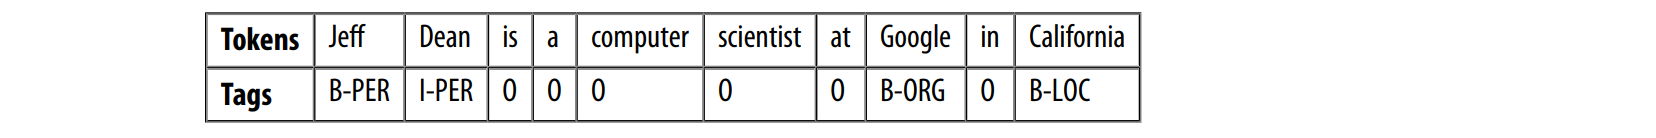

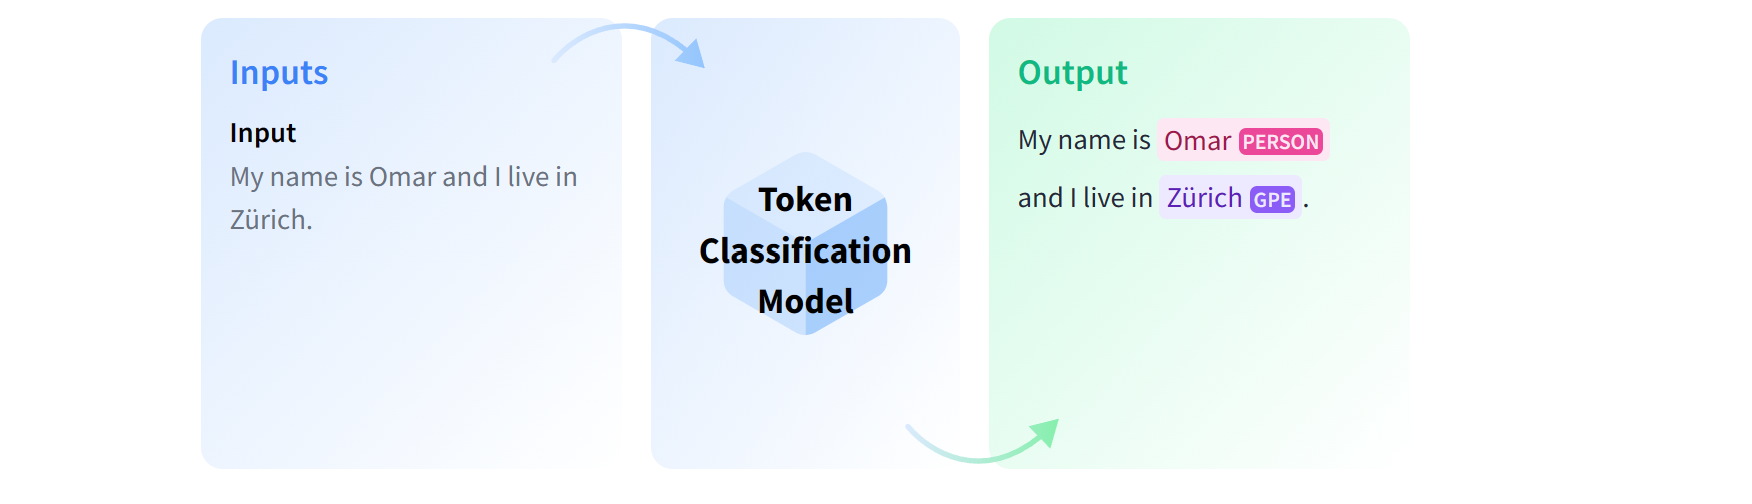
**DEMO:**
https://demos.explosion.ai/displacy-ent

**Text Input:**
NER begins with a piece of text, which can be a sentence, a paragraph, a document, or even a larger corpus of text.

**Tokenization:**
The input text is split into individual words or tokens. This process is called tokenization, and it's a crucial step because NER works on a token-by-token basis.

**Entity Recognition:**       
The tokenized text is analyzed to identify spans of tokens that correspond to named entities. NER systems use various techniques, such as rule-based approaches, machine learning models (like conditional random fields or deep learning models), or a combination of these methods to recognize entities.

**Entity/Token Classification:**
Once the entities are recognized, they are classified into predefined categories like "person," "organization," "location," "date," "number," etc. These categories help organize and provide context to the recognized entities.

**Output:**
The final output of the NER process is a structured representation of the original text with identified named entities and their corresponding categories. This output can be used for various purposes like information extraction, content summarization, sentiment analysis, and more.

## IOB NER Tagging Format
- IOB tagging, which stands for Inside-Outside-Beginning tagging, is a common technique used in named entity recognition (NER) to label tokens in a text sequence to indicate their positions within named entities. It helps identify the starting, inside, and outside parts of entities within the text.

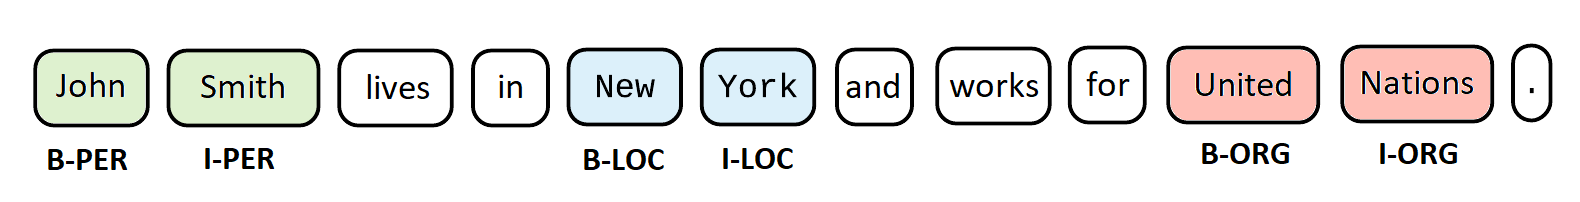
- IOB Tagging:
The tokens within a named entity are tagged as follows:

    - "B" (Beginning): The first token of an entity is tagged with "B" to indicate the beginning of the entity.
    - "I" (Inside): Tokens subsequent to the first token of an entity are tagged with "I" to indicate they are inside the entity.
    - "O" (Outside): Tokens that are not part of any named entity are tagged with "O" to indicate they are outside any entity.

- Tagging Format Article:
    - https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

## THE CONLLPP DATASET:

https://huggingface.co/datasets/conllpp

- CoNLLpp is a corrected version of the CoNLL2003 NER dataset where labels of 5.38% of the sentences in the test set have been manually corrected. The original CoNLL2003 dataset is available at https://www.clips.uantwerpen.be/conll2003/ner/.

```
{
    "tokens": ["SOCCER", "-", "JAPAN", "GET", "LUCKY", "WIN", ",", "CHINA", "IN", "SURPRISE", "DEFEAT", "."],
    "original_ner_tags_in_conll2003": ["O", "O", "B-LOC", "O", "O", "O", "O", "B-PER", "O", "O", "O", "O"],
    "corrected_ner_tags_in_conllpp": ["O", "O", "B-LOC", "O", "O", "O", "O", "B-LOC", "O", "O", "O", "O"],
}

```

```
{
    "chunk_tags": [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 13, 11, 21, 22, 11, 12, 17, 11, 21, 17, 11, 12, 12, 21, 22, 22, 13, 11, 0],
    "id": "0",
    "ner_tags": [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "pos_tags": [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 35, 24, 35, 37, 16, 21, 15, 24, 41, 15, 16, 21, 21, 20, 37, 40, 35, 21, 7],
    "tokens": ["The", "European", "Commission", "said", "on", "Thursday", "it", "disagreed", "with", "German", "advice", "to", "consumers", "to", "shun", "British", "lamb", "until", "scientists", "determine", "whether", "mad", "cow", "disease", "can", "be", "transmitted", "to", "sheep", "."]
}

```

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets

### 1. EXPLORE DATASET:

In [ ]:
import pandas as pd
from datasets import load_dataset

In [ ]:
data = load_dataset('conllpp')
data

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
pd.DataFrame(data['train']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14041 entries, 0 to 14040
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          14041 non-null  object
 1   tokens      14041 non-null  object
 2   pos_tags    14041 non-null  object
 3   chunk_tags  14041 non-null  object
 4   ner_tags    14041 non-null  object
dtypes: object(5)
memory usage: 548.6+ KB


##### UNIQUE TAGS IN THE DATASET:

In [ ]:
feats_dict = data['train'].features
feats_dict

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [ ]:
feats_dict['ner_tags']

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [ ]:
feats_dict['ner_tags'].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

### 2. CREATE A NEW COLUMN FOR NER STR CORRESPONDING TO NER TAGS:

In [ ]:
ner_tags = data['train'].features['ner_tags'].feature.names

ner_tags

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

The NER tags you provided use the IOB (Inside, Outside, Beginning) format, which is a common way to represent named entity annotations. Here's what each of these tags means:

- 'O': This tag indicates that the token is outside of any named entity. It does not belong to any named entity category.

- 'B-PER': This tag indicates that the token is the beginning of a person's name entity. 'PER' stands for 'Person'.

- 'I-PER': This tag indicates that the token is inside a person's name entity, following the token marked as 'B-PER'.

- 'B-ORG': This tag indicates that the token is the beginning of an organization's name entity. 'ORG' stands for 'Organization'.

- 'I-ORG': This tag indicates that the token is inside an organization's name entity, following the token marked as 'B-ORG'.

- 'B-LOC': This tag indicates that the token is the beginning of a location entity. 'LOC' stands for 'Location'.

- 'I-LOC': This tag indicates that the token is inside a location entity, following the token marked as 'B-LOC'.

- 'B-MISC': This tag indicates that the token is the beginning of a miscellaneous named entity. 'MISC' is used for entities that do not fit into the other categories.

- 'I-MISC': This tag indicates that the token is inside a miscellaneous named entity, following the token marked as 'B-MISC'.

Here's an example to illustrate how these tags are used:

```
John   B-PER
Doe    I-PER
works  O
at     O
Google B-ORG
Inc.   I-ORG
in     O
New    B-LOC
York   I-LOC
City   I-LOC
.      O
```

In this example, "John Doe" is tagged as a person's name, "Google Inc." is tagged as an organization, and "New York City" is tagged as a location entity. The 'O' tags indicate tokens that are not part of any named entity.

##### INDEX TO TAG & TAG TO INDEX MAPPINGS:

In [ ]:
index2tag = {idx:tag for idx, tag in enumerate(ner_tags)}
tag2index = {tag:idx for idx, tag in enumerate(ner_tags)}

In [ ]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [ ]:
tag2index

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

##### MAPPING FUNCTION TO BE APPLIED TO NER NUMERICAL TAGS:

In [ ]:
def create_tag_names(batch):
  tag_name = {'ner_str': [index2tag[idx] for idx in batch['ner_tags']]}
  return tag_name

In [ ]:
data = data.map(create_tag_names)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'ner_str'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'ner_str'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'ner_str'],
        num_rows: 3453
    })
})

In [ ]:
data.keys()

dict_keys(['train', 'validation', 'test'])

### 3. RELEVANT COLUMNS:

In [ ]:
df_tr = pd.DataFrame(data['train']).rename(columns={'tokens' : 'words'})
df_val = pd.DataFrame(data['validation']).rename(columns={'tokens' : 'words'})
df_ts = pd.DataFrame(data['test']).rename(columns={'tokens' : 'words'})

drop_cols = 'pos_tags chunk_tags'.split()
df_tr = df_tr.drop(drop_cols, axis = 1)
df_val = df_val.drop(drop_cols, axis = 1)
df_ts = df_ts.drop(drop_cols, axis = 1)

df_tr.head()

,id,words,ner_tags,ner_str
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[3, 0, 7, 0, 0, 0, 7, 0, 0]","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,1,"[Peter, Blackburn]","[1, 2]","[B-PER, I-PER]"
2,2,"[BRUSSELS, 1996-08-22]","[5, 0]","[B-LOC, O]"
3,3,"[The, European, Commission, said, on, Thursday...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,4,"[Germany, 's, representative, to, the, Europea...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."


####  WORDS & THEIR CORRESPONDING NER_TAGS (AN EXAMPLE):

In [ ]:
idx = 0

row = df_tr.iloc[idx][['words', 'ner_str']].to_dict()
df_row = pd.DataFrame(row).T

df_row

,0,1,2,3,4,5,6,7,8
words,EU,rejects,German,call,to,boycott,British,lamb,.
ner_str,B-ORG,O,B-MISC,O,O,O,B-MISC,O,O


### 4. TOKENIZATION (model - "distilbert-base-cased"):

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-cased"
TOKENIZER = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
TOKENIZER.is_fast

True

#### PRE & POST TOKENIZATION:

In [ ]:
inputs = data['train'][0]['tokens']
tokenizer = TOKENIZER(inputs, is_split_into_words=True)

print(f'WORDS: {inputs}')
print()
print(f'TOKENS: {tokenizer.tokens()}')

WORDS: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

TOKENS: ['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


#### TOKENS & CORRESPONDING WORD IDS:

In [ ]:
tokenizer.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [ ]:
pd.DataFrame().assign(tokens = tokenizer.tokens(), word_ids = (tokenizer.word_ids()))

,tokens,word_ids
0,[CLS],NaN
1,EU,0.0
2,rejects,1.0
3,German,2.0
4,call,3.0
5,to,4.0
6,boycott,5.0
7,British,6.0
8,la,7.0
9,##mb,7.0


#### NOTE:
- Notice the word LAMB has been split into 2 parts after tokenization,  
but both parts have the same word id
- 2 new tokens have been added: [CLS] & [SEP] & the ids corresponding are NaN

### 5. ALIGNING LABELS WITH TOKENS:

In [ ]:
labels = data['train'][0]['ner_tags']
word_ids = tokenizer.word_ids()
print(labels, word_ids)


[3, 0, 7, 0, 0, 0, 7, 0, 0] [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]


In [ ]:
def align_labels_with_tokens(labels, word_ids):

  new_labels = []
  current_word=None

  for word_id in word_ids:

    if word_id != current_word:
      current_word = word_id
      label = -100 if word_id is None else labels[word_id]
      new_labels.append(label)

    elif word_id is None:
      new_labels.append(-100) # Pytorch default tagging when there is no tag(cls & sep tokens)

    else:
      label = labels[word_id]

      if label%2==1:
        label = label + 1
      new_labels.append(label)

  return new_labels


In [ ]:
align_labels_with_tokens(labels, word_ids)

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]

#### NOTE:
In pytorch when ids are not used, then they should be replaced by -100

In [ ]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = TOKENIZER(examples['tokens'], truncation=True, is_split_into_words=True)

  all_labels = examples['ner_tags']

  new_labels = []
  for i, labels in enumerate(all_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs['labels'] = new_labels

  return tokenized_inputs


In [ ]:
tokenized_datasets = data.map(tokenize_and_align_labels,
                              batched=True,
                              remove_columns=data['train'].column_names)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

##### FINAL DATASET FOR TRAINING:

In [ ]:
pd.DataFrame(tokenized_datasets['train'])

,input_ids,attention_mask,labels
0,"[101, 7270, 22961, 1528, 1840, 1106, 21423, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]"
1,"[101, 1943, 14428, 102]","[1, 1, 1, 1]","[-100, 1, 2, -100]"
2,"[101, 26660, 13329, 12649, 15928, 1820, 118, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 5, 6, 6, 6, 0, 0, 0, 0, 0, -100]"
3,"[101, 1109, 1735, 2827, 1163, 1113, 9170, 1122...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, ..."
4,"[101, 1860, 112, 188, 4702, 1106, 1103, 1735, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 5, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 1, ..."
...,...,...,...
14036,"[101, 1113, 5286, 131, 102]","[1, 1, 1, 1, 1]","[-100, 0, 0, 0, -100]"
14037,"[101, 1784, 1160, 102]","[1, 1, 1, 1]","[-100, 0, 0, -100]"
14038,"[101, 10033, 123, 8083, 122, 102]","[1, 1, 1, 1, 1, 1]","[-100, 3, 0, 3, 0, -100]"
14039,"[101, 1784, 1210, 102]","[1, 1, 1, 1]","[-100, 0, 0, -100]"


### 6. DATA COLLATOR:

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=TOKENIZER)

In [ ]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch

{'input_ids': tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])}

In [ ]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
batch['input_ids']

tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
batch['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
batch['labels']

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

### 7. METRICS:

In [ ]:
!pip install seqeval
!pip install evaluate

In [ ]:
import evaluate
metric = evaluate.load('seqeval')

In [ ]:
labels = data['train'][0]['ner_tags']
labels = [index2tag[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

Create an prediction example:

In [ ]:
predictions = labels.copy()
predictions[2] = "O"
predictions[-1] = 'B-LOC' # REPLACE LAST ITEM WITH WRONH LABEL

predictions

['B-ORG', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'B-LOC']

In [ ]:
perf = metric.compute(predictions=[predictions], references=[labels], zero_division=0)
pd.DataFrame(perf)

,LOC,MISC,ORG,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.0,1.000000,1.0,0.666667,0.666667,0.666667,0.777778
recall,0.0,0.500000,1.0,0.666667,0.666667,0.666667,0.777778
f1,0.0,0.666667,1.0,0.666667,0.666667,0.666667,0.777778
number,0.0,2.000000,1.0,0.666667,0.666667,0.666667,0.777778


### 8. MODEL TRAINING:

##### IMPORT PRETRAINED MODEL:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
                                                    model_checkpoint,
                                                    id2label=index2tag,
                                                    label2id=tag2index)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config.num_labels

9

##### TRAINING ARGUMENTS:

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments("distilbert-finetuned-ner",
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 2e-5,
                         num_train_epochs=3,
                         weight_decay=0.01)

#####  TRAINER:

##### FUNCTION TO COMPUTE METRICS:

In [ ]:
import numpy as np

def compute_metrics(eval_preds):

    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    true_labels = [[ner_tags[l] for l in label if l!=-100] for label in labels]

    true_predictions = [[ner_tags[p] for p,l in zip(prediction, label) if l!=-100]
                        for prediction, label in zip(predictions, labels)]

    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

    return {"precision": all_metrics['overall_precision'],
            "recall": all_metrics['overall_recall'],
            "f1": all_metrics['overall_f1'],
            "accuracy": all_metrics['overall_accuracy']}

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=args,
                  train_dataset = tokenized_datasets['train'],
                  eval_dataset = tokenized_datasets['validation'],
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=TOKENIZER)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.014600,0.085516,0.903800,0.940761,0.921910,0.982222
2,0.016500,0.087246,0.917380,0.938068,0.927609,0.983340
3,0.009300,0.085762,0.919487,0.941770,0.930496,0.983944


TrainOutput(global_step=5268, training_loss=0.01755055203615216, metrics={'train_runtime': 309.7367, 'train_samples_per_second': 135.996, 'train_steps_per_second': 17.008, 'total_flos': 460431563935266.0, 'train_loss': 0.01755055203615216, 'epoch': 3.0})

### 9. SAVE NER MODEL:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### SAVE LOCALLY:

In [ ]:
model_path = 'drive/My Drive/MODELS/'

trainer.save_model(model_path + "ner_distilbert_finetuned")

##### PUSH TO HF HUB:

In [ ]:
from transformers import pipeline

model_path_ = 'drive/My Drive/MODELS/ner_distilbert_finetuned'
check_point = 'checkpoint-5268'

model_path = model_path_ + check_point
ner_model = pipeline("token-classification",
                     model = model_path,
                     aggregation_strategy="simple")


ner_model.push_to_hub("ner-model")

### 10. USE NER MODEL:
FROM HF HUB:

In [1]:
from transformers import pipeline

ner_model = pipeline("token-classification",
                     model="wizardofchance/ner-model",
                     aggregation_strategy="simple")

config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline

ner_model = pipeline("token-classification",
                     model="wizardofchance/ner-model",
                     aggregation_strategy="simple")

#### IF LOADING FROM MODEL SAVED LOCALLY:

```
from transformers import pipeline
model_path = 'drive/My Drive/MODELS/hf_ner_model/'
check_point = 'checkpoint-5268'

ner_model = pipeline("token-classification",
                            model=model_path + check_point,
                            aggregation_strategy="simple"
                            )
```

### DATA TO TEST NER ON:

In [5]:
import pandas as pd

data_path = 'drive/My Drive/DATA/UN_debates/'

df = pd.read_csv(data_path + 'un-general-debates.csv', encoding = 'utf-8-sig')
dff = (df
 [df.year >= 2010]
 [df.country == 'IND']
 .reset_index(drop = True)
 )

dff

<ipython-input-5-2d7e7ba74f3b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = (df


,session,year,country,text
0,68,2013,IND,"Let me first of all congratulate \nyou, Mr. Pr..."
1,67,2012,IND,﻿It is indeed a great privilege\nfor me to be ...
2,65,2010,IND,"Allow me to begin by \ncongratulating you, Sir..."
3,69,2014,IND,"At the outset, I would like \nto congratulate ..."
4,66,2011,IND,Allow me at the outset to \ncongratulate Mr. A...
5,70,2015,IND,The United Nations is marking its seventieth a...


In [7]:
txt = dff.text.values[5]
txt

'The United Nations is marking its seventieth anniversary this year, making this session of the General Assembly a historic one. I hope that this year will also be historic for the United Nations in terms of outcomes. I would like to assure the President that he will receive India’s full support in his efforts.\nSeventy years ago, the foundations of the United Nations were laid at the San Francisco Conference, in a city on the west coast of this country. India was one of the signatory countries of the Charter of the United Nations, although at that time we were not independent. We obtained our independence two years later. When the United Nations was established, a rather diminutive-looking man with the powerful weapon of non-violence was writing the final act in a struggle that would become a symbol of hope for the colonized and the oppressed everywhere. I am grateful that the United Nations has proclaimed the birthday of this extraordinary man as the International Day of Non-Violence

In [14]:
import re

def f_make_text_chunks(raw_txt):

    txt = raw_txt.replace('\ufeff', '')
    txt_chunks = re.split('\.\s*\n', txt)
    txt_chunks = [txt_chunk.replace('\n', '') for txt_chunk in txt_chunks]
    return txt_chunks


def f_chunk_docs(docs):

    txt_chunks = []
    for doc in docs:
        txt_chunks.extend(f_make_text_chunks(doc))
    return txt_chunks

### NER PREDICTIONS:

In [15]:
idx = 5

raw_txt = dff.text.values[idx]
txt_chunks = f_make_text_chunks(raw_txt)

In [17]:
ner_model(txt_chunks)

[[{'entity_group': 'ORG',
   'score': 0.9977073,
   'word': 'United Nations',
   'start': 4,
   'end': 18},
  {'entity_group': 'ORG',
   'score': 0.9996699,
   'word': 'General Assembly',
   'start': 95,
   'end': 111},
  {'entity_group': 'ORG',
   'score': 0.9993943,
   'word': 'United Nations',
   'start': 180,
   'end': 194},
  {'entity_group': 'LOC',
   'score': 0.9999163,
   'word': 'India',
   'start': 275,
   'end': 280}],
 [{'entity_group': 'ORG',
   'score': 0.99603987,
   'word': 'United Nations',
   'start': 42,
   'end': 56},
  {'entity_group': 'MISC',
   'score': 0.942167,
   'word': 'San Francisco Conference',
   'start': 74,
   'end': 98},
  {'entity_group': 'LOC',
   'score': 0.9998969,
   'word': 'India',
   'start': 145,
   'end': 150},
  {'entity_group': 'MISC',
   'score': 0.8932455,
   'word': 'Charter of the United Nations',
   'start': 193,
   'end': 222},
  {'entity_group': 'ORG',
   'score': 0.99920857,
   'word': 'United Nations',
   'start': 326,
   'end': 34